In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
tweet = pd.read_csv('Data\election_day_tweets.csv', na_values=[' '])
tweet_with_loc = tweet.dropna(subset =['user.location']) # only keep those with location
tweet_with_loc['text'].head()

# get two data set, one for MA, one for WY
df1 = tweet_with_loc[tweet_with_loc['user.location'].str.contains(", MA")]
df2 = tweet_with_loc[tweet_with_loc['user.location'].str.contains(", HI")]
df3 = tweet_with_loc[tweet_with_loc['user.location'].str.contains(", VT")]
df4 = tweet_with_loc[tweet_with_loc['user.location'].str.contains(", RI")]
df5 = tweet_with_loc[tweet_with_loc['user.location'].str.contains(", CA")]

frames = [df1, df2, df3, df4, df5]
df_democ = pd.concat(frames)
df_democ['left'] = 1

df1 = tweet_with_loc[tweet_with_loc['user.location'].str.contains(", NE")]
df2 = tweet_with_loc[tweet_with_loc['user.location'].str.contains(", WY")]
df3 = tweet_with_loc[tweet_with_loc['user.location'].str.contains(", OK")]
df4 = tweet_with_loc[tweet_with_loc['user.location'].str.contains(", KS")]
df5 = tweet_with_loc[tweet_with_loc['user.location'].str.contains(", UT")]
df6 = tweet_with_loc[tweet_with_loc['user.location'].str.contains(", WV")]
df7 = tweet_with_loc[tweet_with_loc['user.location'].str.contains(", NO")]

frames = [df1, df2, df3, df4, df5, df6, df7]
df_rep = pd.concat(frames)
df_rep['left'] = 0
# republication group is smaller, therefore took more state, it could be that in republication state, users are more likely not allowing location funciton on twitter

frames = [df_democ, df_rep]
tweet_subgroup = pd.concat(frames)

In [3]:
df = tweet_subgroup.dropna(subset =['user.location']) # only keep those with location
df = df.reset_index().drop(['index'], axis=1) # reset index

In [4]:
from nltk.tokenize import WordPunctTokenizer
import re
tok = WordPunctTokenizer()
pat1 = r'@[A-Za-z0-9]+'
pat2 = r'https?://[A-Za-z0-9./]+'
combined_pat = r'|'.join((pat1, pat2))
def tweet_cleaner(text):

    stripped = re.sub(combined_pat, '', text)
    try:
        clean = stripped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        clean = stripped
    letters_only = re.sub("[^a-zA-Z]", " ", clean)
    lower_case = letters_only.lower()
    # During the letters_only process two lines above, it has created unnecessay white spaces,
    # I will tokenize and join together to remove unneccessary white spaces
    words = tok.tokenize(lower_case)
    return (" ".join(words)).strip()

testing = df.text[:100]
test_result = []
for t in testing:
    test_result.append(tweet_cleaner(t))

In [5]:
clean_tweet_texts = []
for i in range(0, df.count()[0]):
    clean_tweet_texts.append(tweet_cleaner(df['text'][i]))

In [6]:
clean_df = pd.DataFrame(clean_tweet_texts,columns=['text'])
clean_df['target'] = df.left


In [13]:
# Vectorize, token, count frequency

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
cvec = CountVectorizer()
cvec.fit(clean_df.text) 

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [12]:
len(cvec.get_feature_names())

14092

In [13]:
rep_doc_matrix = cvec.transform(clean_df[clean_df.target == 0].text)
dem_doc_matrix = cvec.transform(clean_df[clean_df.target == 1].text)
rep_tf = np.sum(rep_doc_matrix,axis=0)
dem_tf = np.sum(dem_doc_matrix,axis=0)
rep = np.squeeze(np.asarray(rep_tf))
dem = np.squeeze(np.asarray(dem_tf))
term_freq_df = pd.DataFrame([rep,dem],columns=cvec.get_feature_names()).transpose()

In [14]:
term_freq_df.columns = ['rep', 'dem']
term_freq_df['total'] = term_freq_df['rep'] + term_freq_df['dem']
term_freq_df.sort_values(by='total', ascending=False).iloc[:10]

,rep,dem,total
election,1441,7834,9275
the,982,4963,5945
to,769,3667,4436
vote,616,2860,3476
and,538,2520,3058
congress,351,2262,2613
in,491,2063,2554
for,480,2015,2495
is,404,2004,2408
of,365,1930,2295


In [15]:
from pylab import *
counts = term_freq_df.total
tokens = term_freq_df.index
ranks = arange(1, len(counts)+1)
indices = argsort(-counts)
frequencies = counts[indices]


In [17]:
my_df = clean_df
from sklearn.feature_extraction.text import CountVectorizer
cvec = CountVectorizer(stop_words='english',max_features=10000)
cvec.fit(my_df.text)
document_matrix = cvec.transform(my_df.text)


rep_batches = np.linspace(0,np.shape(rep)[0],10).astype(int)
i=0
rep_tf = []
while i < len(rep_batches)-1:
    batch_result = np.sum(document_matrix[rep_batches[i]:rep_batches[i+1]].toarray(),axis=0)
    rep_tf.append(batch_result)
    #print (rep_batches[i+1],"entries' term freuquency calculated")
    i += 1

In [18]:
dem_batches = np.linspace(np.shape(rep)[0],2*np.shape(rep)[0],10).astype(int)
i=0
dem_tf = []
while i < len(rep_batches)-1:
    batch_result = np.sum(document_matrix[dem_batches[i]:dem_batches[i+1]].toarray(),axis=0)
    dem_tf.append(batch_result)
    #print (dem_batches[i+1],"entries' term freuquency calculated")
    i += 1

In [19]:
rep = np.sum(rep_tf,axis=0)
dem = np.sum(dem_tf,axis=0)
term_freq_df2 = pd.DataFrame([rep,dem],columns=cvec.get_feature_names()).transpose()
term_freq_df2.columns = ['rep', 'dem']
term_freq_df2['total'] = term_freq_df2['rep'] + term_freq_df2['dem']
term_freq_df2.sort_values(by='total', ascending=False).iloc[:10]

,rep,dem,total
election,8957,318,9275
vote,3343,133,3476
congress,2565,48,2613
democrat,1778,112,1890
trump,1371,32,1403
today,1180,51,1231
electionday,1061,29,1090
day,812,38,850
republican,678,46,724
voted,654,24,678


In [20]:
term_freq_df2['dem_rate'] = term_freq_df2['dem'] * 1./term_freq_df2['total']
term_freq_df2.sort_values(by='dem_rate', ascending=False).iloc[:10]



,rep,dem,total,dem_rate
agriculture,0,1,1,1.0
detch,0,2,2,1.0
sadvoter,0,1,1,1.0
breen,0,1,1,1.0
ikky,0,1,1,1.0
britain,0,1,1,1.0
turnutahblue,0,1,1,1.0
brunchbill,0,1,1,1.0
idek,0,1,1,1.0
trusting,0,1,1,1.0


In [21]:

term_freq_df2['dem_freq_pct'] = term_freq_df2['dem'] * 1./term_freq_df2['dem'].sum()
term_freq_df2.sort_values(by='dem_freq_pct', ascending=False).iloc[:10]

,rep,dem,total,dem_rate,dem_freq_pct
election,8957,318,9275,0.034286,0.086272
vote,3343,133,3476,0.038262,0.036082
democrat,1778,112,1890,0.059259,0.030385
today,1180,51,1231,0.041430,0.013836
congress,2565,48,2613,0.018370,0.013022
republican,678,46,724,0.063536,0.012480
day,812,38,850,0.044706,0.010309
race,109,33,142,0.232394,0.008953
trump,1371,32,1403,0.022808,0.008681
voting,587,30,617,0.048622,0.008139


In [22]:
from scipy.stats import hmean

term_freq_df2['dem_hmean'] = term_freq_df2.apply(lambda x: (hmean([x['dem_rate'], x['dem_freq_pct']])
                                                                   if x['dem_rate'] > 0 and x['dem_freq_pct'] > 0 
                                                                   else 0), axis=1)                                                        
term_freq_df2.sort_values(by='dem_hmean', ascending=False).iloc[:10]
#The harmonic mean rank 


,rep,dem,total,dem_rate,dem_freq_pct,dem_hmean
election,8957,318,9275,0.034286,0.086272,0.049070
democrat,1778,112,1890,0.059259,0.030385,0.040172
vote,3343,133,3476,0.038262,0.036082,0.037140
republican,678,46,724,0.063536,0.012480,0.020862
today,1180,51,1231,0.041430,0.013836,0.020744
race,109,33,142,0.232394,0.008953,0.017241
day,812,38,850,0.044706,0.010309,0.016755
congress,2565,48,2613,0.018370,0.013022,0.015241
voting,587,30,617,0.048622,0.008139,0.013944
wv,1,25,26,0.961538,0.006782,0.013470


In [23]:
from scipy.stats import norm
def normcdf(x):
    return norm.cdf(x, x.mean(), x.std())

term_freq_df2['dem_rate_normcdf'] = normcdf(term_freq_df2['dem_rate'])
term_freq_df2['dem_freq_pct_normcdf'] = normcdf(term_freq_df2['dem_freq_pct'])
term_freq_df2['dem_normcdf_hmean'] = hmean([term_freq_df2['dem_rate_normcdf'], term_freq_df2['dem_freq_pct_normcdf']])
term_freq_df2.sort_values(by='dem_normcdf_hmean', ascending=False).iloc[:10]

,rep,dem,total,dem_rate,dem_freq_pct,dem_hmean,dem_rate_normcdf,dem_freq_pct_normcdf,dem_normcdf_hmean
wv,1,25,26,0.961538,0.006782,0.013470,1.000000,1.000000,1.000000
precincts,14,22,36,0.611111,0.005969,0.011822,0.999832,1.000000,0.999916
jim,18,20,38,0.526316,0.005426,0.010741,0.998867,1.000000,0.999433
incumbent,25,22,47,0.468085,0.005969,0.011787,0.996399,1.000000,0.998196
commission,0,11,11,1.000000,0.002984,0.005951,1.000000,0.996262,0.998127
reporting,26,20,46,0.434783,0.005426,0.010718,0.993399,1.000000,0.996689
justice,29,21,50,0.420000,0.005697,0.011242,0.991472,1.000000,0.995718
update,19,11,30,0.366667,0.002984,0.005920,0.979849,0.996262,0.987987
governor,32,16,48,0.333333,0.004341,0.008570,0.967215,0.999958,0.983314
utah,14,8,22,0.363636,0.002170,0.004315,0.978903,0.972574,0.975728


In [24]:
term_freq_df2['rep_rate'] = term_freq_df2['rep'] * 1./term_freq_df2['total']
term_freq_df2['rep_freq_pct'] = term_freq_df2['rep'] * 1./term_freq_df2['rep'].sum()
term_freq_df2['rep_hmean'] = term_freq_df2.apply(lambda x: (hmean([x['rep_rate'], x['rep_freq_pct']])
                                                                   if x['rep_rate'] > 0 and x['rep_freq_pct'] > 0 
                                                                   else 0), axis=1)                                                        
term_freq_df2['rep_rate_normcdf'] = normcdf(term_freq_df2['rep_rate'])
term_freq_df2['rep_freq_pct_normcdf'] = normcdf(term_freq_df2['rep_freq_pct'])
term_freq_df2['rep_normcdf_hmean'] = hmean([term_freq_df2['rep_rate_normcdf'], term_freq_df2['rep_freq_pct_normcdf']])
term_freq_df2.sort_values(by='rep_normcdf_hmean', ascending=False).iloc[:10]




,rep,dem,total,dem_rate,dem_freq_pct,dem_hmean,dem_rate_normcdf,dem_freq_pct_normcdf,dem_normcdf_hmean,rep_rate,rep_freq_pct,rep_hmean,rep_rate_normcdf,rep_freq_pct_normcdf,rep_normcdf_hmean
gt,293,0,293,0.000000,0.000000,0.000000,0.400719,0.463055,0.429638,1.000000,0.002855,0.005693,0.599281,0.995804,0.748256
trumpdumb,232,0,232,0.000000,0.000000,0.000000,0.400719,0.463055,0.429638,1.000000,0.002260,0.004511,0.599281,0.980640,0.743935
gov,210,0,210,0.000000,0.000000,0.000000,0.400719,0.463055,0.429638,1.000000,0.002046,0.004084,0.599281,0.968703,0.740473
read,254,1,255,0.003922,0.000271,0.000507,0.410265,0.563110,0.474687,0.996078,0.002475,0.004937,0.589735,0.988464,0.738731
iwillvote,200,0,200,0.000000,0.000000,0.000000,0.400719,0.463055,0.429638,1.000000,0.001949,0.003890,0.599281,0.961539,0.738371
dumptrump,194,0,194,0.000000,0.000000,0.000000,0.400719,0.463055,0.429638,1.000000,0.001890,0.003773,0.599281,0.956635,0.736920
youth,189,0,189,0.000000,0.000000,0.000000,0.400719,0.463055,0.429638,1.000000,0.001841,0.003676,0.599281,0.952172,0.735592
vetstwitter,187,0,187,0.000000,0.000000,0.000000,0.400719,0.463055,0.429638,1.000000,0.001822,0.003637,0.599281,0.950287,0.735029
sss,187,0,187,0.000000,0.000000,0.000000,0.400719,0.463055,0.429638,1.000000,0.001822,0.003637,0.599281,0.950287,0.735029
civiced,187,0,187,0.000000,0.000000,0.000000,0.400719,0.463055,0.429638,1.000000,0.001822,0.003637,0.599281,0.950287,0.735029


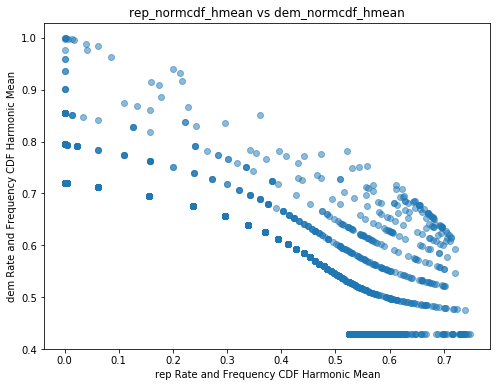

If a data point is near to upper left corner, it is more likely from a tweet at the democratic party controlled state, and if it is closer to the bottom right corner, it is more likely from the republican controlled state.


In [30]:
plt.figure(figsize=(8,6))
ax = sns.regplot(x="rep_normcdf_hmean", y="dem_normcdf_hmean",fit_reg=False, scatter_kws={'alpha':0.5},data=term_freq_df2)
plt.ylabel('dem Rate and Frequency CDF Harmonic Mean')
plt.xlabel('rep Rate and Frequency CDF Harmonic Mean')
plt.title('rep_normcdf_hmean vs dem_normcdf_hmean')
plt.show()

print ('If a data point is near to upper left corner, it is more likely from a tweet at the democratic party controlled state, and if it is closer to the bottom right corner, it is more likely from the republican controlled state.')